In [1]:
!pip install dask-ml

In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import earthaccess
import h5netcdf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyinterp.backends.xarray  # Module that handles the filling of undefined values.
import pyinterp.fill
import seaborn as sns
import xarray as xr
import rioxarray as rxr
from matplotlib.patches import Rectangle
import logging
import xarray as xr
import dask.array as da
from dask_ml.decomposition import PCA
from dask_ml.cluster import KMeans
from dask.diagnostics import ProgressBar
from dask.distributed import Client

In [3]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
log = logging.getLogger()

auth = earthaccess.login()
client = Client()

2025-08-06 19:48:18,554 - INFO - You're now authenticated with NASA Earthdata Login


In [4]:
tspan = ("2025-02-01", "2025-02-28")
bbox = (137.874, -39.520, 153.719, -29.906)
res_rf = earthaccess.search_data(
    short_name="PACE_OCI_L3M_SFREFL",
    temporal=tspan,
    granule_name='*.MO.*0p1deg*',
    bounding_box=bbox
)
path_rf = earthaccess.open(res_rf)
ds_rf = xr.open_mfdataset(path_rf, combine="nested", concat_dim="date")


# Cut out AOI
min_lon, max_lat, max_lon, min_lat = bbox
ds_rf = ds_rf.sel(lat=slice(min_lat, max_lat), lon=slice(min_lon, max_lon))

2025-08-06 19:48:28,742 - INFO - Granules found: 1
2025-08-06 19:48:44,880 - INFO - Opening 1 granules, approx size: 1.56 GB
2025-08-06 19:48:44,880 - INFO - using endpoint: https://obdaac-tea.earthdatacloud.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
# 3. Select wavelengths for RGB
wavelengths_rgb = [660, 550, 470]  # nm, approximate visible RGB centers
wavelength_idx = [int(abs(ds_rf.wavelength - wl).argmin()) for wl in wavelengths_rgb]

# 4. Extract RGB bands from rhos
rhos = ds_rf['rhos'].isel(date=0, wavelength=wavelength_idx)  # shape: (lat, lon, 3)

# 5. Rearrange to (3, lat, lon)
rgb = rhos.transpose('wavelength', 'lat', 'lon')

# 6. Normalize and convert to 8-bit
rgb = rgb.clip(min=0)
rgb_uint8 = (rgb / rgb.max() * 255).astype("uint8")

# 7. Assign CRS and spatial dims
rgb_uint8.rio.set_spatial_dims(x_dim='lon', y_dim='lat', inplace=True)
rgb_uint8.rio.write_crs("EPSG:4326", inplace=True)

# 8. Save as GeoTIFF
rgb_uint8.rio.to_raster("pace_rgb_truecolor.tif")

/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/array/chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)


In [6]:
# Remove extra vars
dims_to_remove = {'rgb', 'eightbitcolor'}
vars_to_drop = [var for var in ds_rf.data_vars
                if dims_to_remove & set(ds_rf[var].dims)]
ds_rf = ds_rf.drop_vars(vars_to_drop)

# Set to the desired wavelengths
rhos = [550, 704, 804]
ds_rf.sel(wavelength=rhos)

# Subset out training dataset
min_lon_train, max_lat_train, max_lon_train, min_lat_train = (137.645, -31.715, 153.673, -30.104)
ds_train = ds_rf.sel(lat=slice(min_lat_train, max_lat_train), lon=slice(min_lon_train, max_lon_train))

In [7]:
def prep_tile(tile):
    """Reshape a small tile: stack lat/lon and flatten features."""
    log.info(f"Preparing tile with shape {tile.sizes}")
    stacked = tile.stack(samples=("lat", "lon")).transpose("samples", "date", "wavelength")
    X = stacked.data
    log.info(f"  -> stacked shape: {X.shape}, chunks: {X.chunks}")
    X = da.where(da.isnan(X), 0, X)
    X = X.rechunk({0: -1, 1: -1, 2: -1})  # ensure fully rechunked before reshape
    X_flat = X.reshape((X.shape[0], -1))
    log.info(f"  -> reshaped to: {X_flat.shape}, chunks: {X_flat.chunks}")
    return X_flat, stacked

def predict_on_tiles(ds, model, tile_size=200):
    lat_chunks = range(0, ds.dims["lat"], tile_size)
    lon_chunks = range(0, ds.dims["lon"], tile_size)

    predicted_tiles = []

    for lat_start in lat_chunks:
        lat_end = min(lat_start + tile_size, ds.dims["lat"])
        row_tiles = []
        log.info(f"  Processing lat slice {lat_start}:{lat_end}")

        for lon_start in lon_chunks:
            lon_end = min(lon_start + tile_size, ds.dims["lon"])
            log.info(f"  → lon slice {lon_start}:{lon_end}")
            tile = ds["rhos"].isel(lat=slice(lat_start, lat_end), lon=slice(lon_start, lon_end))

            if tile.count().values == 0:
                log.info("Skipping empty tile")
                continue

            try:
                X_flat, stacked = prep_tile(tile)
                X_np = X_flat.compute()
                labels = model.predict(X_np)
                labels_xr = xr.DataArray(labels, coords={"samples": stacked["samples"]}, dims="samples")
                labels_unstacked = labels_xr.unstack("samples")
                row_tiles.append(labels_unstacked)
                log.info(f"  Finished prediction on tile")
            except Exception as e:
                log.warning(f"  Failed to process tile: {e}")
                continue

        if row_tiles:
            log.info(f"Concatenating row tiles along 'lon'")
            predicted_row = xr.concat(row_tiles, dim="lon")
            predicted_tiles.append(predicted_row)

    if predicted_tiles:
        log.info("Concatenating all rows into full label map")
        full_labels = xr.concat(predicted_tiles, dim="lat")
        return full_labels

    log.warning("No tiles were processed successfully.")
    return None

In [8]:
log.info("Training model on subset...")
X_train, _ = prep_tile(ds_train['rhos'])
X_train_np = X_train.compute()
log.info(f"Training data shape: {X_train_np.shape}")

model = KMeans(n_clusters=10, random_state=42)
model.fit(X_train_np)
log.info("KMeans model fitted.")

2025-08-06 19:48:59,719 - INFO - Training model on subset...
2025-08-06 19:48:59,720 - INFO - Preparing tile with shape Frozen({'date': 1, 'lat': 16, 'lon': 158, 'wavelength': 122})
2025-08-06 19:48:59,724 - INFO -   -> stacked shape: (2528, 1, 122), chunks: ((2370, 158), (1,), (8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 2))
2025-08-06 19:48:59,727 - INFO -   -> reshaped to: (2528, 122), chunks: ((2528,), (122,))
2025-08-06 19:49:03,073 - INFO - Training data shape: (2528, 122)
2025-08-06 19:49:03,075 - INFO - Starting _check_array
2025-08-06 19:49:03,126 - INFO - Finished _check_array in 0:00:00.050715
2025-08-06 19:49:03,128 - INFO - Starting init_scalable
2025-08-06 19:49:03,128 - INFO - Initializing with k-means||
2025-08-06 19:49:03,773 - INFO - Starting init iteration  1/ 8 ,  1 centers
2025-08-06 19:49:03,862 - INFO - Finished init iteration  1/ 8 ,  1 centers in 0:00:00.089390
2025-08-06 19:49:03,906 - INFO - Starting init iteration  2/ 8 ,  6 centers
2025-08-06 19:49:04,172 

2025-08-06 19:50:02,358 - INFO - Starting tile-wise prediction...
2025-08-06 19:50:02,359 - INFO -   Processing lat slice 0:96
2025-08-06 19:50:02,360 - INFO -   → lon slice 0:158
2025-08-06 19:50:14,190 - INFO - Preparing tile with shape Frozen({'date': 1, 'lat': 96, 'lon': 158, 'wavelength': 122})
2025-08-06 19:50:14,201 - INFO -   -> stacked shape: (15168, 1, 122), chunks: ((158, 2528, 2528, 2528, 2528, 2528, 2370), (1,), (8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 2))
2025-08-06 19:50:14,204 - INFO -   -> reshaped to: (15168, 122), chunks: ((15168,), (122,))
2025-08-06 19:50:29,196 - INFO - Starting _check_array
2025-08-06 19:50:29,266 - INFO - Finished _check_array in 0:00:00.069990
2025-08-06 19:50:29,277 - INFO -   Finished prediction on tile
2025-08-06 19:50:29,277 - INFO - Concatenating row tiles along 'lon'
2025-08-06 19:50:29,279 - INFO - Concatenating all rows into full label map
2025-08-06 19:50:29,281 - INFO - Prediction complete. Plotting result...


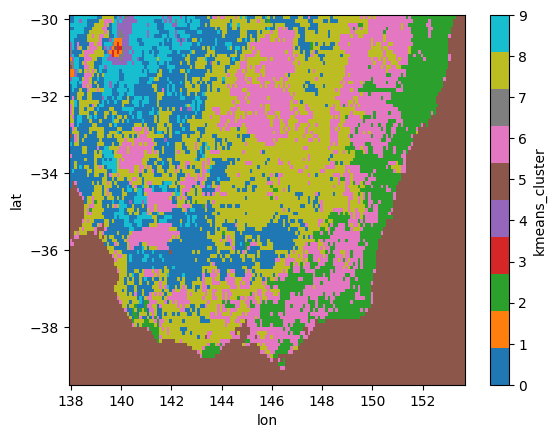

In [15]:
log.info("Starting tile-wise prediction...")
labels_2d = predict_on_tiles(ds_rf, model, tile_size=200)

if labels_2d is not None:
    labels_2d.name = "kmeans_cluster"
    log.info("Prediction complete. Plotting result...")
    labels_2d.plot.imshow(cmap='tab10')
else:
    log.error("Clustering failed: no valid output generated.")


In [17]:
log.info("Writing output to GeoTIFF...")
labels_2d = labels_2d.sortby("lat", ascending=False)
labels_2d.rio.set_spatial_dims(x_dim='lon', y_dim='lat')
labels_2d.rio.write_crs("EPSG:4326", inplace=True)
labels_2d.rio.to_raster("kmeans_clusters.tif")
log.info("GeoTIFF saved as kmeans_clusters.tif")

2025-08-06 19:51:28,750 - INFO - Writing output to GeoTIFF...
2025-08-06 19:51:28,809 - INFO - GeoTIFF saved as kmeans_clusters.tif


In [19]:
ds_with_labels = ds_rf.copy()
ds_with_labels['cluster'] = labels_2d
ds_with_labels

<xarray.Dataset> Size: 7MB
Dimensions:      (date: 1, lat: 96, lon: 158, wavelength: 122)
Coordinates:
  * wavelength   (wavelength) float64 976B 346.0 351.0 ... 2.131e+03 2.258e+03
  * lat          (lat) float32 384B -29.95 -30.05 -30.15 ... -39.35 -39.45
  * lon          (lon) float32 632B 138.0 138.1 138.2 ... 153.5 153.6 153.7
    spatial_ref  int64 8B 0
Dimensions without coordinates: date
Data variables:
    rhos         (date, lat, lon, wavelength) float32 7MB dask.array<chunksize=(1, 1, 158, 8), meta=np.ndarray>
    cluster      (lat, lon) int32 61kB dask.array<chunksize=(24, 158), meta=np.ndarray>
Attributes: (12/62)
    product_name:                      PACE_OCI.20250201_20250228.L3m.MO.SFRE...
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    cdm_data_type:                     grid
    identifier_product_doi_authority:  http://dx.doi.org
    identifier_product_doi:            10.5067/PACE/OCI/L3M/SFREFL/3.0
    data_bins:                         5325334
    data_minimum:                      -0.05000001
    data_maximum:                      1.0

In [20]:
rhos = ds_with_labels['rhos'].values  # shape: (lat, lon, wavelength)
clusters = ds_with_labels['cluster'].values  # shape: (lat, lon)
wavelengths = ds_with_labels['wavelength'].values

rhos_single = np.squeeze(rhos, axis=0)  # squeeze out the "date" or "time" dimension

rhos_flat = rhos_single.reshape(-1, rhos_single.shape[-1])  

clusters_flat = clusters.ravel()


cluster_ids = np.unique(clusters_flat[~np.isnan(clusters_flat)]).astype(int)

spectra_per_cluster = []

for cid in cluster_ids:
    mask = clusters_flat == cid                    # shape: (lat*lon,)
    cluster_rhos = rhos_flat[mask, :]              # shape: (N, wavelength)
    mean_spectrum = cluster_rhos.mean(axis=0)
    spectra_per_cluster.append((cid, mean_spectrum))


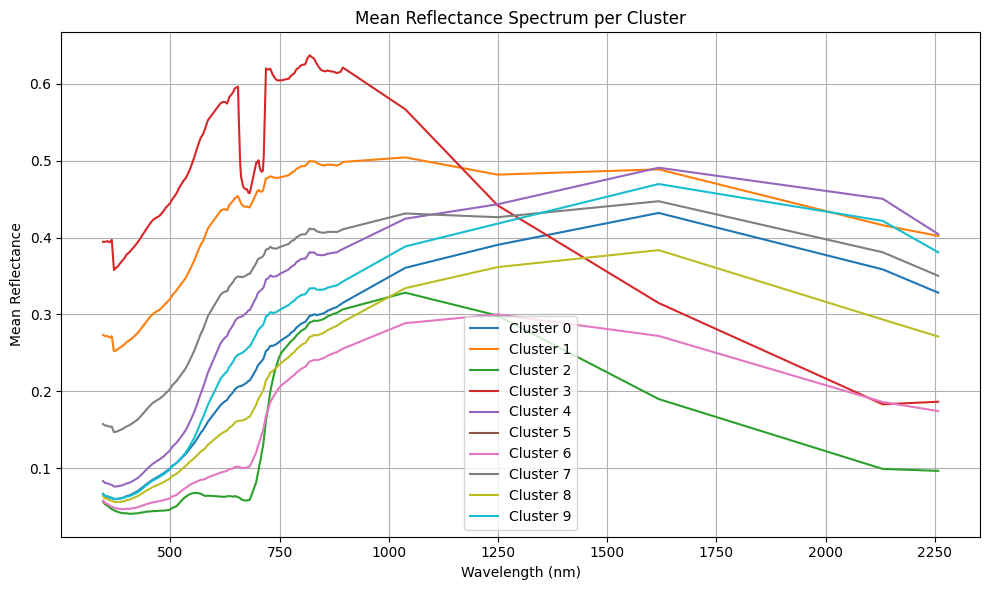

In [21]:
plt.figure(figsize=(10, 6))
for cid, spectrum in spectra_per_cluster:
    plt.plot(wavelengths, spectrum, label=f'Cluster {cid}')

plt.xlabel('Wavelength (nm)')
plt.ylabel('Mean Reflectance')
plt.title('Mean Reflectance Spectrum per Cluster')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()